# 04. PyTorch Custom Datasets

We'll use `torchvision.datasets` to build custom datasets. 

#### The contents

Topic	Contents
0. Importing PyTorch and setting up device-agnostic code.
1. Get data	We're going to be using our own custom dataset of pizza, steak and sushi images.
2. Become one with the data (data preparation)	
3. Transforming data - here we'll look at some steps we can take to transform our images so they're ready to be used with a model.
4. Loading data with ImageFolder (option 1)	 ImageFolder is helpful if our images are in standard image classification format.
5. Loading image data with a custom Dataset	What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of torch.utils.data.Dataset.
6. Other forms of transforms (data augmentation) 
7. Model 0: TinyVGG without data augmentation
8. Exploring loss curves
9. Model 1: TinyVGG with data augmentation
10. Compare model results	
11. Making a prediction on a custom image trained model predict on an image outside of our existing dataset.

### 1.Get data from GitHub

In [12]:
import requests
import zipfile
from pathlib import Path 

# setup data folder 
data_path = Path("D:\\Coding_Stuff\\GitHub\\ZTM-PyTorch\\data")
image_path = data_path / "pizza_steak_sushi"

# if imagefolder does not exist 
if image_path.is_dir():
    print(f"{image_path} directory exists ")
else:
    print(f"Did not find {image_path} directory , creaitng one...")

    with open(data_path / "/pizza_steak_sushi.zip", "wb") as f:
        image_path.mkdir(parents=True, exist_ok=True)

        link = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

        request = requests.get(link)
        f.write(request.content)

        # unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / "/pizza_steak_sushi.zip", "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data ... ")
            zip_ref.extractall(image_path)


Did not find D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi directory , creaitng one...
Unzipping pizza, steak, sushi data ... 


### 2. Becomming one with the data

Preparing data...... 

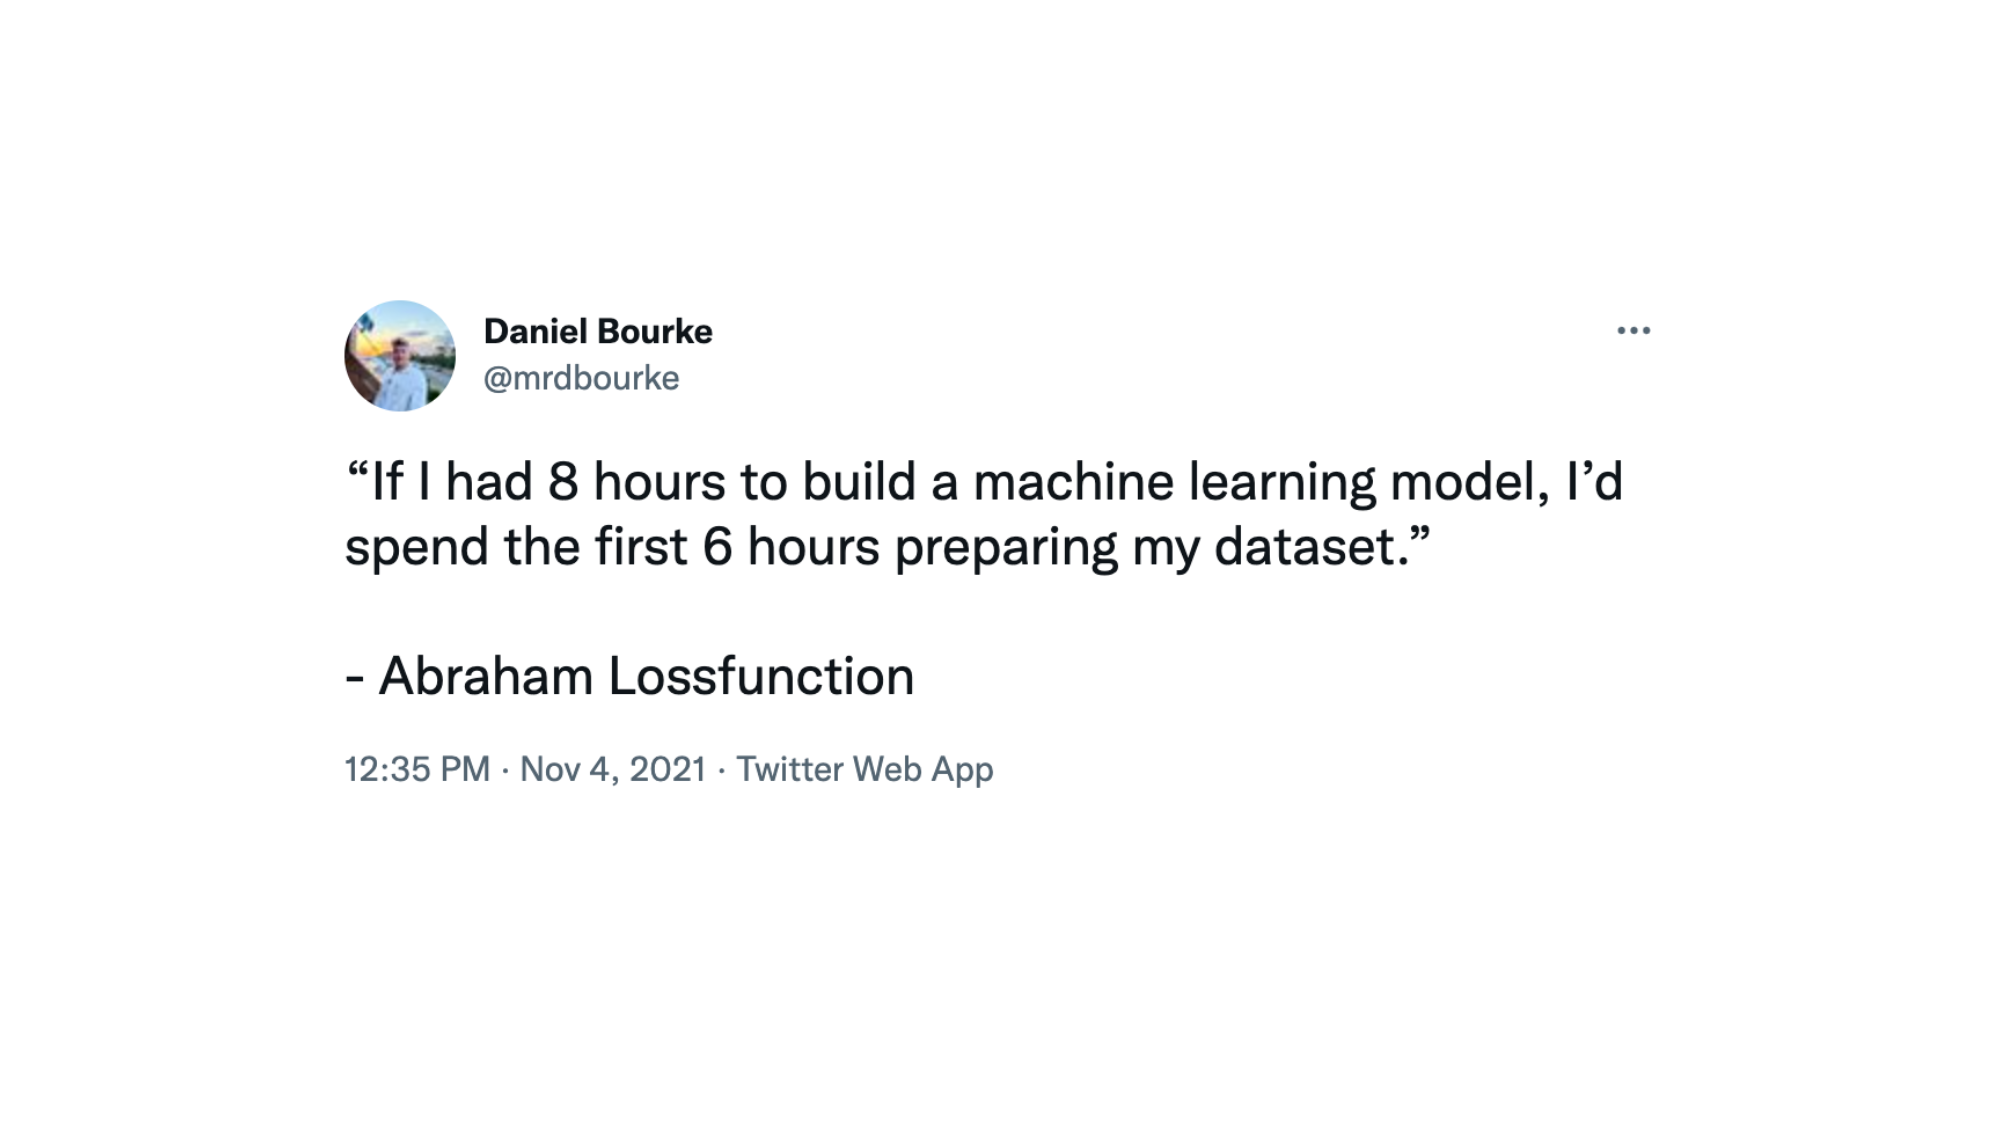
